## On-Time Performance Analysis:
####   I will illustrate how the Machine Learning Process can help identify 'Delay-Prone' flights ~potentially saving an airline over 600 million/ year

I am using ‘On-Time Performance’ data obtained from the United States Department of Transportation Site, which covers passenger airline travel within the US from 1987 to the present.  For my exploration and analysis, I have chosen my customer to be Southwest Airlines.    I have restricted my research to include Southwest’s data from 01/01/2014 through 02/28/2015.

**0.1.1  QUESTION 1**: 
Can we predict and estimate the value of an ‘Aircraft Arrival Delay’ using machine learning (Linear Regression) methods?.    

Business Application for Hypothesis I:
The advantages of predicting arrival delays are numerous for airline corporations.  Primarily, ‘Timeliness of Arrival’ is the first benchmark utilized to rank airlines in the Customer Experience Benchmark  (Reference ACSI Travel Report 2015).     Hence, improved on-time performance, can lead to increased customer loyalty.   Further, airlines often pay customers a compensation fee for arrival delay.   With arrival delay predictions and estimations, airlines will be able to ‘pad’ the scheduled aircraft arrival time and thus prevent the delay altogether.

If airlines are able to identify which flights have a high probability of delay, then they will also have the ability to take the following actions:
•	Tailor manpower for specific flights that have a high probability of delay
•	Tailor the flight schedule (if specific flight dates or airports are especially prone to delays)
•	Utilize potential delay information for fiscal planning 


By utilizing the scientific method, EDA and machine learning I will test Question 1.
I will begin the process by pulling in the subject 01/2014-02/2015 data  and restricting ‘UniqueCarrier’ to Southwest.

In [1]:
import seaborn as sns

In [1]:
% pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import pandas as pd
import seaborn as sns
from __future__ import division
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.options.display.mpl_style = 'default'

In [47]:
import sklearn
from sklearn import feature_selection as f_select
from sklearn.cross_validation import train_test_split
from sklearn import metrics
from sklearn.cross_validation import cross_val_score

In [6]:
mydf=pd.read_csv("ALL_DATA.csv")

**0.1.2 DATA CLEANING**

The following table illustrates that our retrieved data includes 1,364,847 samples.  However, not all of the ‘ArrDelayMinutes’ (ADM) target values are available.   Because of the direct relationship between ADM and DepDelayMinutes (DDM) (shown below in section 0.1.4) , I will fill ADM with the available DDM values and fill the remaining missing values in with the mean ADM value.  I also filled the missing ‘DepTime’ values by finding the average departure time for each ‘FlightNum’ value (by using a’ groupby ‘ & aggs function) and filling 
In DepTime for these average values.  

In [295]:
mydf.describe()

,Unnamed: 0,index,Month,DayOfWeek,DepDelayMinutes,ArrDelayMinutes,DepTime,ArrTime,Distance,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,TaxiOut,TaxiIn,FlightNum,target,tran_taxi,tran_dist,tran_in
count,1364847.000000,1364847.00000,1364847.000000,1364847.000000,1344727.000000,1364847.000000,1344727.000000,1343790.000000,1364847.000000,334690.000000,334690.000000,334690.000000,334690.000000,334690.000000,1344526.000000,1343790.000000,1364847.000000,1.341341e+06,1344526.000000,1364847.000000,1343790.000000
mean,682423.000000,3361959.93137,5.859859,3.901061,15.402803,14.221670,1346.332453,1492.631024,716.450982,14.847058,1.613944,6.591278,0.044841,27.921895,11.598122,5.798865,1866.592647,-inf,2.361211,6.393146,1.636135
std,393997.535764,1931295.40660,3.624987,1.976821,32.421771,31.945116,475.125422,511.405645,444.312033,30.767265,12.764624,16.375500,1.342381,39.288600,6.188811,3.996851,1516.409562,NaN,0.394646,0.604052,0.450693
min,0.000000,255041.00000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,148.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,-inf,0.000000,4.997212,0.000000
25%,341211.500000,1618970.50000,2.000000,2.000000,0.000000,0.000000,933.000000,1112.000000,369.000000,0.000000,0.000000,0.000000,0.000000,1.000000,8.000000,4.000000,541.000000,NaN,2.079442,5.910797,1.386294
50%,682423.000000,3180210.00000,6.000000,4.000000,2.000000,0.000000,1335.000000,1521.000000,589.000000,6.000000,0.000000,0.000000,0.000000,16.000000,10.000000,5.000000,1404.000000,NaN,2.302585,6.378426,1.609438
75%,1023634.500000,4924617.50000,9.000000,6.000000,17.000000,14.221670,1742.000000,1919.000000,957.000000,16.000000,0.000000,7.000000,0.000000,35.000000,13.000000,6.000000,3134.000000,2.639057e+00,2.564949,6.863803,1.791759
max,1364846.000000,6598093.00000,12.000000,7.000000,843.000000,825.000000,2400.000000,2400.000000,2447.000000,825.000000,680.000000,506.000000,207.000000,683.000000,177.000000,246.000000,4999.000000,6.715383e+00,5.176150,7.802618,5.505332


In [7]:
# Fillna for 'DepTime':


FNgb=mydf.groupby(['FlightNum'])
FNgb=FNgb.agg({'DepTime':'mean'})
FNgb.head()
            
    
FNgb=FNgb.reset_index()

#  Creating dict for FlightNum & Average Departure times
fbdic={}

for i in FNgb.index:
    fbdic[FNgb.FlightNum[i]]=FNgb.DepTime[i]


mydf['create']=mydf.FlightNum.map(fbdic.get)

In [8]:
# Populating Missing Arrival times based on 'fbdic' dictionary: 

FNgb=mydf.groupby(['FlightNum'])
FNgb=FNgb.agg({'ArrTime':'mean'})
FNgb.head()
            
    
FNgb=FNgb.reset_index()
fbdic2={}

for i in FNgb.index:
    fbdic2[FNgb.FlightNum[i]]=FNgb.ArrTime[i]
    
mydf['ArrTime']=mydf['ArrTime'].fillna(mydf.create)

In [9]:
# Populating Missing Departure times based on 'fbdic' dictionary: 
mydf['DepTime']=mydf['DepTime'].fillna(mydf.create)

In [10]:
mydf.TaxiOut=mydf.TaxiOut.fillna(mydf.TaxiOut.mean())

In [11]:
mydf.TaxiIn=mydf.TaxiIn.fillna(mydf.TaxiIn.mean())

**0.1.3  FEATURES AND FEATURE GENERATION**:
Because Southwest will be utilizing the results of this analysis for long term planning purposes and forecasting, I only will be using features that Southwest will be able to determine in advance.    For example: ‘DepartureDelayMinutes’ (DDM)  has a very direct correlation with ArrivalDelayMinutes,  but I won’t use this feature because Southwest will not be able to determine this variable in advance.

Feature Generation:

1) Layover Minutes:
The number of minutes between flights seems to be a powerful predictor for delays (if there is a longer ‘layover’, the technical crew will have more time to address the problem before departure.   Thus, I will create a new feature column (‘Between’)  based on the layover time between consecutive flights for identical ‘Tailnumbers ‘ at identical airports. (Note: in order to calculate this correctly, I created two additional columns: ‘Scheduleduled_Dep = Deptime-DepDelayMinutes and Scheduled_Arr=ArrTime-ArrDelayMinutes)

2) Airport Rankings
I also created a feature (‘Best_Origins’) based on the ‘delay ranking’ of each origin airport.  The origin that had incurred the least amount of delays (within the dataset) received a rank of ‘0’.     I then created a similar feature called ‘Best_Dest’ based off of Destination rankings.


Feature Choice: 

3) FlightNum:   
I choose this feature because of its predictive potential due to its inherent order (small flight numbers occur early in the day, etc)
Note that if a flight is late in the day, it is more likely that the flight will be delayed due to previous delays that were incurred and accumulated throughout the day.  

4) Distance:    
I chose ‘Distance’ because (based on the following table), we can see that not all flights that incurred departure delays result in delays upon arrival.   If the subject flight is relatively long, we can assume that some time lost during a departure delay could be potentially recovered during the flight.

5) TaxiIn and TaxiOut
Naturally, I chose ‘Taxi’ features because long taxi times could in turn result in arrival delays.


In [12]:
# 1 'Developing 'Between' Feature ~ Layover Minutes

mydf=mydf.sort(['TailNum','FlightDate','DepTime'])
mydf['Scheduled_Dep']=mydf.DepTime-mydf.DepDelayMinutes
mydf['Scheduled_Arr']=mydf.ArrTime-mydf.ArrDelayMinutes

In [13]:
# Getting value and then test for 'Between'

mydf['Between']=mydf.Scheduled_Dep-mydf.Scheduled_Arr.shift(1)
mydf.Between=mydf.Between.where(mydf.FlightDate== mydf.FlightDate.shift(1),mydf.Origin== mydf.Dest.shift(1))
mydf.Between=mydf.Between.where(mydf.TailNum== mydf.TailNum.shift(1))

In [14]:
mydf.Between=mydf.Between.fillna(mydf.Between.mean())

In [15]:
# Determine if a delay occurred (or not) for each sample (will need this for following cell.. 

def GROUPS(x):
    if x==0:
        return 0
    else:
        return 1

mydf['IsDelay']=mydf.ArrDelayMinutes.apply(GROUPS)

In [16]:
mydf.describe()

,Unnamed: 0,index,Month,DayOfWeek,DepDelayMinutes,ArrDelayMinutes,DepTime,ArrTime,Distance,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,TaxiOut,TaxiIn,FlightNum,target,tran_taxi,tran_dist,tran_in,create,Scheduled_Dep,Scheduled_Arr,Between,IsDelay
count,1364847.000000,1364847.00000,1364847.000000,1364847.000000,1344727.000000,1364847.000000,1364846.000000,1364846.000000,1364847.000000,334690.000000,334690.000000,334690.000000,334690.000000,334690.000000,1364847.000000,1364847.000000,1364847.000000,1.341341e+06,1344526.000000,1364847.000000,1343790.000000,1364846.000000,1344727.000000,1364846.000000,1364847.000000,1364847.000000
mean,682423.000000,3361959.93137,5.859859,3.901061,15.402803,14.221670,1346.244588,1490.290327,716.450982,14.847058,1.613944,6.591278,0.044841,27.921895,11.598122,5.798865,1866.592647,-inf,2.361211,6.393146,1.636135,1346.244588,1330.929650,1476.068657,60.037107,0.479636
std,393997.535764,1931295.40660,3.624987,1.976821,32.421771,31.945116,472.224913,508.388838,444.312033,30.767265,12.764624,16.375500,1.342381,39.288600,6.142566,3.965899,1516.409562,NaN,0.394646,0.604052,0.450693,197.514742,465.508034,505.922225,63.867512,0.499585
min,0.000000,255041.00000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,148.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,-inf,0.000000,4.997212,0.000000,7.000000,-535.000000,-520.000000,-2310.000000,0.000000
25%,341211.500000,1618970.50000,2.000000,2.000000,0.000000,0.000000,937.000000,1113.000000,369.000000,0.000000,0.000000,0.000000,0.000000,1.000000,8.000000,4.000000,541.000000,NaN,2.079442,5.910797,1.386294,1218.222222,929.000000,1108.000000,30.000000,0.000000
50%,682423.000000,3180210.00000,6.000000,4.000000,2.000000,0.000000,1335.000000,1516.000000,589.000000,6.000000,0.000000,0.000000,0.000000,16.000000,10.000000,5.000000,1404.000000,NaN,2.302585,6.378426,1.609438,1343.452381,1325.000000,1505.000000,70.000000,0.000000
75%,1023634.500000,4924617.50000,9.000000,6.000000,17.000000,14.221670,1739.000000,1915.000000,957.000000,16.000000,0.000000,7.000000,0.000000,35.000000,13.000000,6.000000,3134.000000,2.639057e+00,2.564949,6.863803,1.791759,1472.398703,1725.000000,1895.000000,81.000000,1.000000
max,1364846.000000,6598093.00000,12.000000,7.000000,843.000000,825.000000,2400.000000,2400.000000,2447.000000,825.000000,680.000000,506.000000,207.000000,683.000000,177.000000,246.000000,4999.000000,6.715383e+00,5.176150,7.802618,5.505332,2165.800000,2325.000000,2400.000000,2170.000000,1.000000


In [17]:
# 2 'Developing Airport Rankings' : (Following illustrates 'Best Airports' ~ fewest delays)

rank=mydf.groupby(['Origin'])
rank=rank.agg({'IsDelay':'sum'})


rank=rank.sort('IsDelay')
rank=rank.reset_index()

rank.head()

,Origin,IsDelay
0,BKG,223
1,EYW,257
2,JAN,288
3,PNS,380
4,RIC,423


In [18]:
# create Origin ranks dictionary
ranks={}

for i in rank.index:
    ranks[rank.Origin[i]]=i

In [19]:
# creating features for Airport Rankings: 
mydf['Best_Origin']=mydf.Origin.apply(lambda x: ranks[x])
mydf['Best_Dest']=mydf.Dest.apply(lambda x: ranks[x])

**0.1.4 VISUALIZATION **

I can visualize the relationship between my chosen features and my target variable: ArrDelayMinutes(ADM) using Matplotlib’s scatterplot matrix.  The matrix illustrates how any two variables relate to each other and along the diagonal a histogram is displayed for the ith variable.  By studying the scatter matrix plot below, we can see that there is some correlation between ‘DepTime’, ‘Best_Dest’ and ‘Best_Origin’, and either neutral or inverse relationships for the rest of the variables.   


In [ ]:
visual=mydf[['ArrDelayMinutes','DepTime','Distance','TaxiOut','TaxiIn','FlightNum','Between','Best_Origin','Best_Dest']]
pd.scatter_matrix(visual, figsize=(20, 20))

<img src="scatterplot.png">

**0.1.5  CONCLUSION:**

At this point, I’ve determined that the predictive power for the selected features is relatively weak for ADM prediction.  I will abandon the idea of a continuous target variable and move onto classification as follows. 


**0.2.1  QUESTION 2**:   
Can we predict if an Arrival Delay will occur or not by using machine learning methods for classification?
Note: The business application described in Question 1  also applies to Question 2.


**0.2.2  GENERATING  THE TARGET VARIABLE**:   
I will use the 'IsDelay' column ( binary value based on whether a delay occurred (whether ADM = 0) or not) as my target variable.  We see target variable distribution below:

In [ ]:
sns.set_style('white')
plt.figure(figsize=(8,6))
plt.hist(mydf.IsDelay,bins=10)
plt.title('Histogram of Target Variable: IsDelay')

<img src="histogram.png">

**0.2.3    FEATURE CHOICE & TRANSFORMING CATEGORICAL DATA**

I will begin my classification analysis using the same features developed for Question 1.   I am interested in exploring the predictive power of Decision trees for my next model.   Decision Trees are known to handle both continuous and binary features relatively well.    As follows, I will convert categorical variables for ‘Month’  and ‘DayOfWeek’.  I will determine which months and days to adjoin to my model based on their relative predictive strength  (predictive strength was determined by calculating the mean ‘IsDelay’ value for each month and weekday (month calculations shown below).   (Note: I also tested ‘TailNum’, to see if any aircraft performed relatively poorly.  However, no aircraft passed the predictive threshold test).

In [20]:
mydf['DayOfWeek'] = mydf.DayOfWeek.map({7:'Sunday',1:'Monday',2:'Tuesday',3:'Wednesday',4:'Thursday',5:'Friday',6:'Saturday'})

In [21]:
mean=mydf.IsDelay.mean()
print mean

std=mydf.IsDelay.std()
print std

0.479636179
0.499585325707


In [22]:
# Following test will determine which days of the week exceed the mean for the expected number of delays, 
# We see that Monday, Thursdays and Friday exceed the mean
list = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']

day_keep=[]

for i in list:
    test = mydf[mydf.DayOfWeek==(i)].IsDelay.mean()
    print test
    if test > (mean):
        day_keep.append(i)

print day_keep

0.484759080801
0.467628307692
0.478642317602
0.51844062933
0.508925064802
0.422211335499
0.464508394598
['Monday', 'Thursday', 'Friday']


In [23]:
# As follows, I use 'get_dummies' to convert Monday, Thursdays and Friday to Binary Features
these=pd.get_dummies(mydf.DayOfWeek)
these=these[day_keep]
mydf=mydf.join(these)

In [24]:
mydf['MONTH'] = mydf.Month.map({12:'Dec',1:'Jan',2:'Feb',3:'Mar',4:'Apr',5:'May',6:'Jun',7:'Jul',8:'Aug',9:'Sep',10:'Oct',11:'Nov'})

In [28]:
list=['Dec','Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov']

month_keep=[]

for i in list:
    test = mydf[mydf.MONTH==(i)].IsDelay.mean()
    print test
    if test > (mean):
        month_keep.append(i)

print month_keep

0.502022244692
0.484796927027
0.466521318661
0.525359531278
0.497825626331
0.514737877388
0.562654959184
0.531381904066
0.45820252757
0.402867368377
0.407276061134
0.393158907433
['Dec', 'Jan', 'Mar', 'Apr', 'May', 'Jun', 'Jul']


In [ ]:
# As follows, I use 'get_dummies' to convert the ['Dec', 'Jan', 'Mar', 'Apr', 'May', 'Jun', 'Jul'] to features
these=pd.get_dummies(mydf.MONTH)
these=these[month_keep]
mydf=mydf.join(these)

In [30]:
mydf.TaxiOut=mydf.TaxiOut.fillna(mydf.TaxiOut.mean())

In [31]:
mydf.TaxiIn=mydf.TaxiIn.fillna(mydf.TaxiIn.mean())

In [41]:
# Defining x & y vectors for analysis: 
x=mydf.drop('IsDelay',1)
y=mydf.IsDelay

**0.2.4    MODEL SELECTION & FEATURE SELECTION**:  

I will use sklearn’s ‘DecisionTreeClassifier’ algorithm for my initial model. 

In [45]:
# Function accepts a classifier, and then provides output score.. 
def assess_classifier(classifier,X, Y):
    from sklearn import cross_validation
    from sklearn import metrics
    
    
    xtrain, xtest, ytrain, ytest = cross_validation.train_test_split(X, Y, test_size=0.2, random_state=1234)
    model=classifier
    clf = model.fit(xtrain, ytrain)
    print clf

    #Print the accuracy on the test and training dataset
    training_accuracy = clf.score(xtrain, ytrain)
    test_accuracy = clf.score(xtest, ytest)
    
    
    #print classifier
    #print "Accuracy on training data: %0.2f" % (training_accuracy)
    print "Accuracy on test data:     %0.2f" % (test_accuracy)
    

    predicted=clf.predict(xtest)
    cm=metrics.confusion_matrix(ytest,predicted)
    
    precision= metrics.average_precision_score(ytest,predicted)
    
    print "Precision on training data: %0.2f" %(precision)
    print cm

In [46]:
# baseline Decision Tree
from sklearn import tree
assess_classifier(tree.DecisionTreeClassifier(),x,y)

DecisionTreeClassifier(compute_importances=None, criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_density=None, min_samples_leaf=1, min_samples_split=2,
            random_state=None, splitter='best')
Accuracy on test data:     0.72
Precision on training data: 0.77
[[104517  37629]
 [ 38359  88253]]


The accuracy of the above model is 0.69.    This ‘baseline’ model can certainly be improved upon.  
From the following Gini feature importance list, we can see that the strongest features are 'DepTime','Between'
and 'FlightNum'
 

In [10]:
from sklearn import tree
clf = tree.DecisionTreeClassifier()
print pd.Series(clf.fit(x, y).feature_importances_, index=x.columns)

Month          0.042209
DepTime        0.249469
Distance       0.078536
TaxiOut        0.089550
TaxiIn         0.065121
FlightNum      0.097623
Between        0.183641
Best_Origin    0.066412
Best_Dest      0.058973
Monday         0.011833
Thursday       0.011346
Friday         0.011643
Dec            0.003079
Jan            0.004384
Mar            0.005097
Apr            0.005604
May            0.005287
Jun            0.005306
Jul            0.004887
dtype: float64


In [47]:
from sklearn.tree import DecisionTreeClassifier
treeclf = tree.DecisionTreeClassifier()

x_tran=clf.fit_transform(x,y)
assess_classifier(tree.DecisionTreeClassifier(),x_tran,y)

DecisionTreeClassifier(compute_importances=None, criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_density=None, min_samples_leaf=1, min_samples_split=2,
            random_state=None, splitter='best')
Accuracy on test data:     0.72
Precision on training data: 0.77
[[105167  36979]
 [ 37957  88655]]


**Feature Selection and Model Optimization:**        
We can see from the above, that when run a decision tree on our transformed x (feature) array, the Accuracy score improved slighlty (to 0.73).   Note that our feature array has gone from 20 features to 6.

I will use the following grid_search SKlearn tool to optimize the Decision Tree Model further.  GridSearch performs an exhaustive search on the Decision Tree parameter values and will return optimal parameters based on the precision score.

**Note about scoring:**
From here on, I will be using 'precision' as my scoring metric (in lieu of accuracy).  Because (as we will see in the final cost benefit section), I am most concerned about true positives.   As such, precision score will help me optimize the model by maximizing true positives

In [12]:
from sklearn import cross_validation
xtrain, xtest, ytrain, ytest =cross_validation.train_test_split(x_tran, y, test_size=0.2, random_state=1234)

In [18]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import grid_search
parameters = {'max_depth':[1,6], 'max_features':[1,6], 'min_samples_split':(10,100,1000,10000), 'min_samples_leaf':(10,100,1000,10000)} 
clf=DecisionTreeClassifier()
treeclf = grid_search.GridSearchCV(clf,parameters,scoring='precision')
treeclf.fit(xtrain,ytrain)

GridSearchCV(cv=None,
       estimator=DecisionTreeClassifier(compute_importances=None, criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_density=None, min_samples_leaf=1, min_samples_split=2,
            random_state=None, splitter='best'),
       fit_params={}, iid=True, loss_func=None, n_jobs=1,
       param_grid={'max_features': [1, 6], 'min_samples_split': (10, 100, 1000, 10000), 'max_depth': [1, 6], 'min_samples_leaf': (10, 100, 1000, 10000)},
       pre_dispatch='2*n_jobs', refit=True, score_func=None,
       scoring='precision', verbose=0)

In [19]:
treeclf.best_estimator_

DecisionTreeClassifier(compute_importances=None, criterion='gini',
            max_depth=6, max_features=6, max_leaf_nodes=None,
            min_density=None, min_samples_leaf=10, min_samples_split=10000,
            random_state=None, splitter='best')

As per grid_search the following parameters were foudn to be optimal: 
-   'Max_depth' :  Max depth of tree  Best Result: 6
-	‘Max_features’:   (Number of features to  consider when looking for the best split).  Best Result:  6
-	‘Min_samples_split’: (Min. number of samples required to split an internal node).  Best Result:  10  (chosen from exp. scale of 1 thru 10^5)
-	‘Min_samples_leaf: (Min number of samples required to be at a leaf node).   Best Result: 10 (chosen from exp. scale of 1 thru 10^5)

The choice of the the max_depth parameter = 6 can be illustrated with the following visualization: 

Best score: 0.766157706646
Best depth: 6


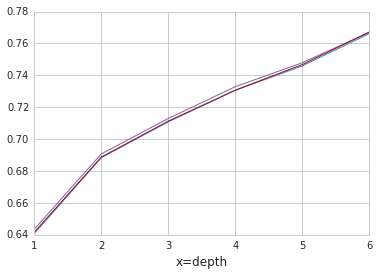

In [66]:
% matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')

all_scores = []
best_score = 0
best_depth = 0

best=[1,2,3,4,5,6]
for i in best:
    treereg = DecisionTreeClassifier(max_depth=i, random_state=1)
    scores = cross_val_score(treereg, xtrain, ytrain, cv=3, scoring='roc_auc')
    current_score = scores
    # If the score mean is better than the current best, or best is the default, then update
    if current_score[0] > best_score:
        best_score = current_score[0]
        best_depth = i
    # store to plot anyway!
    all_scores.append(current_score)
    
print "Best score: %s" % best_score
print "Best depth: %s" % best_depth

# now actually fit the model
treereg = DecisionTreeClassifier(max_depth=best_depth, random_state=1)
treereg.fit(x_tran, y)

plt.figure()
plt.plot(range(1,7), all_scores)
plt.xlabel('x=depth')


In [20]:
treeclf = tree.DecisionTreeClassifier(max_depth=6,max_features=6,min_samples_split=10, min_samples_leaf=10)
assess_classifier(treeclf,x_tran,y)

DecisionTreeClassifier(compute_importances=None, criterion='gini',
            max_depth=6, max_features=6, max_leaf_nodes=None,
            min_density=None, min_samples_leaf=10, min_samples_split=10,
            random_state=None, splitter='best')
Accuracy on training data: 0.71
Precision on training data: 0.76


**Utilizing Ensemble Methods:**     
We can improve upon our Decision Tree scores by using the RandomForest Classifier - 
The Sklearn RandomForest Classifier allows us to sample trees using 
the bootstrap method - The best split is chosen among a random sampling of features- (thus,  we will not set specific parameters values) 
We can improve our model because of this sampling, as bias increases (due to increased sampling) 

Note our second iteration of RandomForests is composed of 100 Trees - - 

In [48]:
from sklearn.ensemble import RandomForestClassifier
rfclf=RandomForestClassifier()
assess_classifier(rfclf,x_tran,y)

RandomForestClassifier(bootstrap=True, compute_importances=None,
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_density=None, min_samples_leaf=1,
            min_samples_split=2, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0)
Accuracy on test data:     0.77
Precision on training data: 0.82
[[119700  22446]
 [ 38366  88246]]


In [49]:
from sklearn.ensemble import RandomForestClassifier
rfclf=RandomForestClassifier(n_estimators=100)
assess_classifier(rfclf,x_tran,y)

RandomForestClassifier(bootstrap=True, compute_importances=None,
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_density=None, min_samples_leaf=1,
            min_samples_split=2, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0)
Accuracy on test data:     0.80
Precision on training data: 0.84
[[118829  23317]
 [ 31572  95040]]


In [50]:
from sklearn.ensemble import ExtraTreesClassifier
exclf=ExtraTreesClassifier()
assess_classifier(exclf,x_tran,y)

ExtraTreesClassifier(bootstrap=False, compute_importances=None,
           criterion='gini', max_depth=None, max_features='auto',
           max_leaf_nodes=None, min_density=None, min_samples_leaf=1,
           min_samples_split=2, n_estimators=10, n_jobs=1, oob_score=False,
           random_state=None, verbose=0)
Accuracy on test data:     0.77
Precision on training data: 0.82
[[119305  22841]
 [ 38062  88550]]


For our final Decision Tree Refinement step : I will use the ExtraTreesClassifier (using 100 Trees!).
The ETC goes one step further than the RandomForest classifer, by randomizing the discriminative threshold for each candidate feature.   This step should ensure a reduction in the model's variance as well as a slight increase in bias.

As we can see, below this final step allowed us to increase our final precision score to 0.84.

In [52]:
from sklearn.ensemble import ExtraTreesClassifier
exclf=ExtraTreesClassifier(n_estimators=100)
assess_classifier(exclf,x_tran,y)

ExtraTreesClassifier(bootstrap=False, compute_importances=None,
           criterion='gini', max_depth=None, max_features='auto',
           max_leaf_nodes=None, min_density=None, min_samples_leaf=1,
           min_samples_split=2, n_estimators=100, n_jobs=1,
           oob_score=False, random_state=None, verbose=0)
Accuracy on test data:     0.79
Precision on training data: 0.83
[[117358  24788]
 [ 30314  96298]]


**0.2.5 COST BENEFIT AND CONCLUSION:**   
Although our final precision score of 0.83 could be improve upon, this result is acceptable for the subject business application.  


The value of correct predictions can be estimated by calculating the amount of money saved by avoiding
potential customer late arrival reimbursement fees minus the crew's hourly cost.

(CB based on: Approx_#_Filled_seats=130, Reimbursement_per_customer=$25, Approx_crew_hourly=$150, Approx_#_crew=5)

ratio of true positive = 0.437      
ratio of false positive=0.092     
ratio of false negative = .112    

saved_by_true_positive_= 0.437*((130*25)-150*5)= 1092     
cost_of_false_positive_= 0.092*(150*5)= 69     
cost_of_false_negative_= 0.112*(130*25) = 364    
(Note that there is no cost associated with a True Negative)

The potential cost savings per flight is $659.  
SouthWest schedules over a million flights per year.  The potential cost savings is immense.

